## Holonomic RRT

In [1]:
import typing as ty

import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d
import tqdm.auto as tqdm

In [2]:
class Obstacle:

    def __init__(self, x: float, y: float, z: float, shape: ty.Tuple[float, float, float]):
        self.x = x
        self.y = y
        self.z = z
        self.shape = shape

    def render(self, ax):
        def cuboid_data(box):
            l = box[3] - box[0]
            w = box[4] - box[1]
            h = box[5] - box[2]
            x = [[0, l, l, 0, 0],
                [0, l, l, 0, 0],
                [0, l, l, 0, 0],
                [0, l, l, 0, 0]]
            y = [[0, 0, w, w, 0],
                [0, 0, w, w, 0],
                [0, 0, 0, 0, 0],
                [w, w, w, w, w]]
            z = [[0, 0, 0, 0, 0],
                [h, h, h, h, h],
                [0, 0, h, h, 0],
                [0, 0, h, h, 0]]
            return box[0] + np.array(x), box[1] + np.array(y), box[2] + np.array(z)

        box = [self.x, self.y, self.z, self.shape[0], self.shape[1], self.shape[2]]
        x, y, z = cuboid_data(box)
        ax.plot_surface(x, y, z, rstride=1, cstride=1, color=(0.1, 0.15, 0.3, 0.2), zorder = 1)

    @classmethod
    def cuboid_obstacle_from_vertices(cls, v: ty.Tuple[float, float, float], shape: ty.Tuple[float, float, float]):
        return cls(v[0] + shape[0] / 2, v[1] + shape[1] / 2, v[2] + shape[2] / 2, shape)
        
    def __str__(self):
        return f"[Obstacle with center at position x={self.x}, y={self.y}, z={self.z}, and dimensions={self.shape}]"

    def __repr__(self):
        return str(self)


class Pose:

    def __init__(self, x: float, y: float, z: float, theta: float = 0, phi: float = 0):
        self.x = x
        self.y = y
        self.z = z
        self.theta = theta
        self.phi = phi
        self.psi = 0.0

    def render(self, ax, color: str = 'g'):
        ax.scatter(self.x, self.y, self.z, color=color)

    @property
    def vector(self):
        return np.array([self.x, self.y, self.z, self.theta, self.phi, self.psi])

    def __str__(self):
        return f"[Robot Pose with position x={self.x}, y={self.y}, z={self.z} and theta={self.theta}, phi={self.phi}, psi={self.psi}]"

    def __repr__(self):
        return str(self)

    def collides(self, obstacle: Obstacle):
        return (abs(self.x - obstacle.x) < obstacle.shape[0] / 2) and (abs(self.y - obstacle.y) < obstacle.shape[1] / 2) and (abs(self.z - obstacle.z) < obstacle.shape[2] / 2)

    def distance(self, other_pose):
        return np.sqrt((self.x - other_pose.x) ** 2 + (self.y - other_pose.y) ** 2 + (self.z - other_pose.z) ** 2)


class Control:

    def __init__(self, phi: float, theta: float, thrust: float):
        self.theta = theta
        self.phi = phi
        self.thrust = thrust

    def transform(self, time: float, pose: Pose):
        theta = self.theta + pose.theta
        phi = self.phi + pose.phi
        psi = pose.psi

        ax = (np.cos(phi) * np.sin(theta) * np.cos(psi) + np.sin(phi) * np.sin(psi)) * self.thrust
        ay = (np.cos(phi) * np.sin(theta) * np.sin(psi) + np.sin(phi) * np.cos(psi)) * self.thrust
        az = (np.cos(phi) * np.cos(theta)) * self.thrust - 10

        pos = np.array([
            [ax * time * time],
            [ay * time * time],
            [az * time * time]
        ])
        pos = pos.reshape(-1)
        return Pose(pose.x + pos[0], pose.y + pos[1], pose.z + pos[2], theta, phi)

    def render(self, ax: plt.Axes, time: float, pose: Pose):
        previous_pose = pose
        next_pose = self.transform(time, previous_pose)
        ax.plot(
            [next_pose.x, previous_pose.x],
            [next_pose.y, previous_pose.y],
            [next_pose.z, previous_pose.z],
            color = 'g'
        )

    def __str__(self):
        return f"[Robot Control action with theta={self.theta}, phi={self.phi} and thrust={self.thrust}]"

    def __repr__(self):
        return str(self)


class Environment:

    def __init__(self, obstacles: ty.List[Obstacle], starting_pose: Pose, target_pose: Pose):
        self.obstacles = obstacles
        self.starting_pose = starting_pose
        self.target_pose = target_pose
    
    def render(self, ax):
        for obstacle in self.obstacles:
            obstacle.render(ax=ax)
        self.starting_pose.render(ax=ax, color='r')
        self.target_pose.render(ax=ax, color='b')

    def valid_pose(self, pose: Pose):
        if not (-2 <= pose.x and pose.x <= 102 and -2 <= pose.y and pose.y <= 102 and -2 <= pose.z and pose.z <= 102):
            return False
        for obstacle in self.obstacles:
            if pose.collides(obstacle):
                return False
        return True

In [3]:
env_default = Environment(
    obstacles = [
        Obstacle.cuboid_obstacle_from_vertices((-5, 25, 0), (20, 35, 60)),
        Obstacle.cuboid_obstacle_from_vertices((30, 25, 0), (55, 35, 100)),
        Obstacle.cuboid_obstacle_from_vertices((45, 35, 0), (55, 60, 60)),
        Obstacle.cuboid_obstacle_from_vertices((45, 75, 0), (55, 85, 100)),
        Obstacle.cuboid_obstacle_from_vertices((-5, 65, 0), (30, 70, 100)),
        Obstacle.cuboid_obstacle_from_vertices((70, 50, 0), (80, 80, 100)),
    ],
    starting_pose = Pose(0, 0, 0),
    target_pose = Pose(100, 100, 100),
)

env_custom = Environment(
    obstacles = [
        Obstacle.cuboid_obstacle_from_vertices((40, 25, 0), (20, 35, 60)), 
        Obstacle.cuboid_obstacle_from_vertices((-5, 25, 0), (55, 35, 100)),
        Obstacle.cuboid_obstacle_from_vertices((45, 35, 0), (55, 60, 60)),

        Obstacle.cuboid_obstacle_from_vertices((70, 50, 0), (80, 80, 100)),
        Obstacle.cuboid_obstacle_from_vertices((-5, 65, 0), (30, 70, 100)),
        Obstacle.cuboid_obstacle_from_vertices((45, 75, 0), (55, 85, 100)),
    ],
    starting_pose = Pose(0, 0, 0),
    target_pose = Pose(100, 100, 100),
)

chosen_environment = input("Enter the environment to run on (default/custom)")
env = env_custom if 'c' in chosen_environment else env_default

/tmp/ipykernel_16358/3706353180.py:2: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = mpl_toolkits.mplot3d.axes3d.Axes3D(fig)


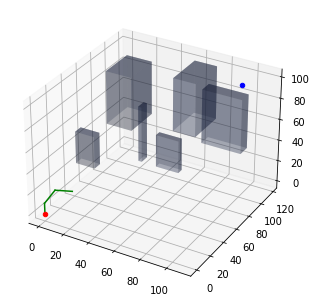

In [4]:
fig = plt.figure()
ax = mpl_toolkits.mplot3d.axes3d.Axes3D(fig)
fig.add_axes(ax)

env.render(ax)
pose = env.starting_pose
for control in [Control(0.0, 0.0, 20.0), Control(np.pi / 4, 0.0, 20.0), Control(- np.pi / 4, np.pi / 4, 20.0)]:
    control.render(ax, 1.0, pose)
    pose = control.transform(1.0, pose)

plt.show()

100%|██████████| 10000/10000 [01:12<00:00, 138.15it/s]
/tmp/ipykernel_16358/674258020.py:43: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = mpl_toolkits.mplot3d.axes3d.Axes3D(fig)


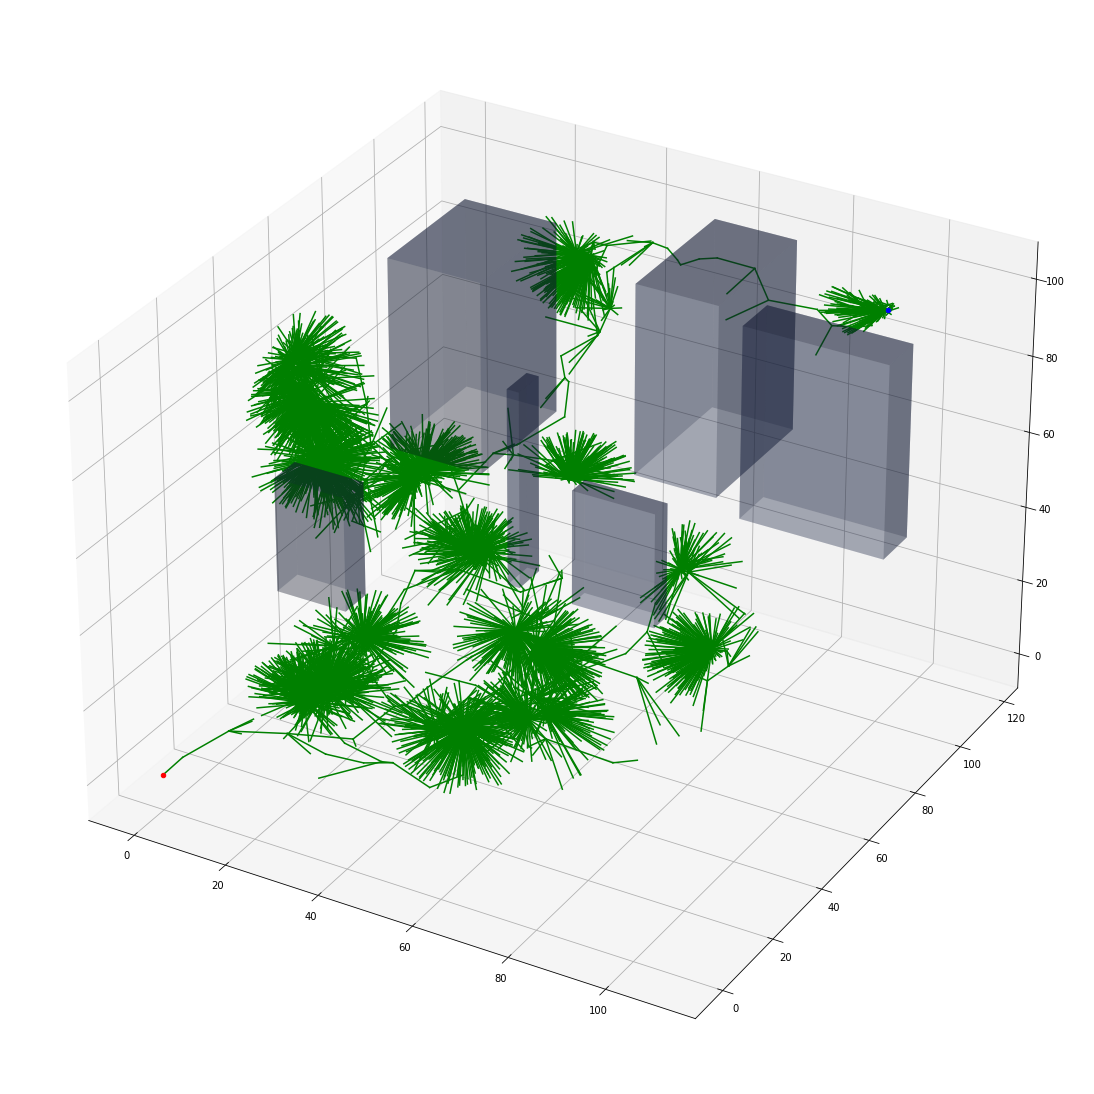

In [5]:
class RRTSearch:

    def __init__(self, env):
        self.env = env
        self.poses = [env.starting_pose]
        self.controls = [None]
        self.parents = [None]
        self.time = 0.5
        self.pseudo_goals = list(filter(env.valid_pose, [Pose(np.random.random() * 100, np.random.random() * 100, np.random.random() * 100) for i in range(40)]))

    def sample_node(self):
        selected_target = np.random.choice(
            [env.target_pose] + self.pseudo_goals,
            p=[(0.2 if i == 0 else 0.8 / len(self.pseudo_goals)) for i in range(len(self.pseudo_goals) + 1)]
        )
        d = np.array([pose.distance(selected_target) for pose in self.poses])
        # d = (1 / d) ** 1.5
        # d = d / np.sum(d)
        c = np.argmin(d)  # np.random.choice(np.arange(len(self.poses)), p=d)
        return c

    def sample_control(self):
        return Control(
            np.random.normal(0, np.pi / 4), 
            np.random.normal(0, np.pi / 4), 
            np.clip(np.random.normal(40, 20), 5.0, 50.0)
        )

    def extend_node(self, idx):
        control = self.sample_control()
        pose = control.transform(self.time, self.poses[idx])
        if env.valid_pose(pose):
            self.poses.append(pose)
            self.controls.append(control)
            self.parents.append(idx)

    def compute(self, steps=5000):
        for _i in tqdm.trange(steps):
            self.extend_node(self.sample_node())

    def render(self):
        fig = plt.figure(figsize=(15, 15))
        ax = mpl_toolkits.mplot3d.axes3d.Axes3D(fig)
        fig.add_axes(ax)
        env.render(ax)
        for idx in range(1, len(self.controls)):
            self.controls[idx].render(ax, self.time, self.poses[self.parents[idx]])
        plt.show()

    def path(self):
        d = np.array([pose.distance(env.target_pose) for pose in self.poses])
        index = np.argmin(d)
        path = []
        while index != None:
            path.append(index)
            index = self.parents[index]
        return list(reversed(path))


np.random.seed(10)
rrt = RRTSearch(env)
rrt.compute(10000)
rrt.render()

/tmp/ipykernel_16358/3860653730.py:4: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = mpl_toolkits.mplot3d.axes3d.Axes3D(fig)


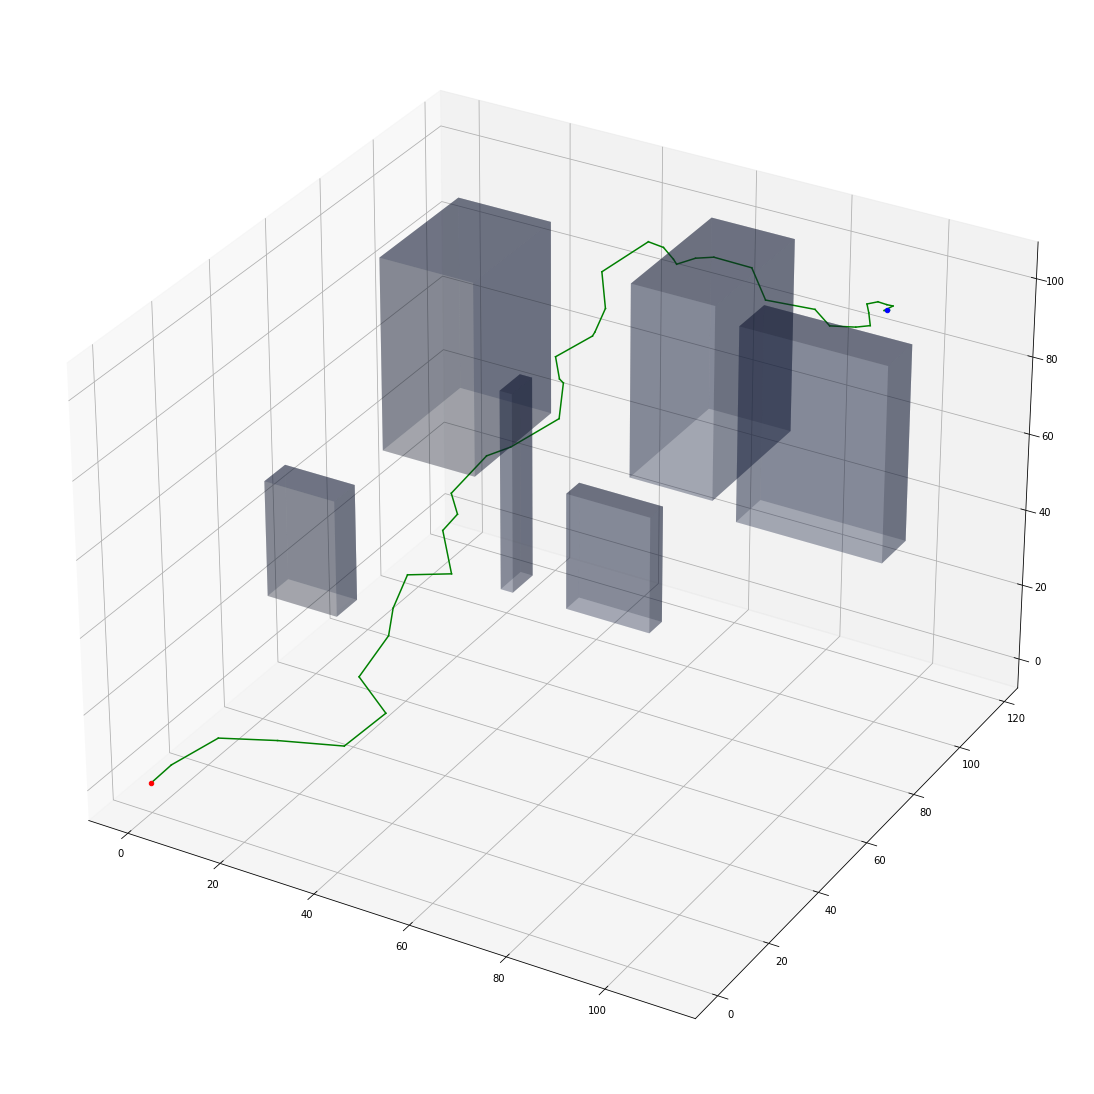

In [6]:
path = rrt.path()

fig = plt.figure(figsize=(15, 15))
ax = mpl_toolkits.mplot3d.axes3d.Axes3D(fig)
fig.add_axes(ax)

env.render(ax)
for iteration, idx in enumerate(path[1:]):
    rrt.controls[idx].render(ax, rrt.time, rrt.poses[rrt.parents[idx]])
plt.show()

In [7]:
class HolonomicRRT:

    def __init__(self, env, rrt):
        self.env = env
        self.rrt = rrt
        self.name = f"drone_{chosen_environment}"
    
    # implement holonomic RRT 
    
    def show_path(self):
        """
        Create a new directory (say non_holonomic_path) and save snapshots of the robot moving along the
        trajectory found by RRT at every step with the step index.
        e.g: snap1.png, snap2.png ...
        """
        path = rrt.path()

        fig = plt.figure(figsize=(15, 15))
        ax = mpl_toolkits.mplot3d.axes3d.Axes3D(fig)
        fig.add_axes(ax)

        env.render(ax)
        for iteration, idx in tqdm.tqdm(enumerate(path[1:])):
            rrt.controls[idx].render(ax, rrt.time, rrt.poses[rrt.parents[idx]])
            fig.savefig(f"videos/path_{self.name}/snap_{iteration}.png")

    def plot_controls(self):
        path = rrt.path()

        theta = []
        phi = []
        thrust = []

        for idx in tqdm.tqdm(path[1:]):
            theta.append(rrt.controls[idx].theta)
            phi.append(rrt.controls[idx].phi)
            thrust.append(rrt.controls[idx].thrust)

        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].plot(theta)
        ax[0].set_title("Theta")
        ax[1].plot(phi)
        ax[1].set_title("Phi")
        ax[2].plot(thrust)
        ax[2].set_title("Thrust")
        fig.savefig(f"outputs/controls_{self.name}.png")
        plt.show()

    def show_tree(self):
        """
        Create a new directory (say non_holonomic_tree) and save snapshots of the evolution of the RRT tree
        at every step with the step index.
        e.g: snap1.png, snap2.png ...
        """
        fig = plt.figure(figsize=(15, 15))
        ax = mpl_toolkits.mplot3d.axes3d.Axes3D(fig)
        fig.add_axes(ax)

        self.env.render(ax)
        counter = 0
        for idx in tqdm.trange(1, len(self.rrt.controls)):
            self.rrt.controls[idx].render(ax, self.rrt.time, self.rrt.poses[self.rrt.parents[idx]])
            if (idx + 1) % 100 == 0:
                fig.savefig(f"videos/tree_{self.name}/snap_{counter}.png")
                counter += 1

/tmp/ipykernel_16358/2359235635.py:19: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = mpl_toolkits.mplot3d.axes3d.Axes3D(fig)
42it [00:07,  5.90it/s]
/tmp/ipykernel_16358/2359235635.py:56: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = mpl_toolkits.mplot3d.axes3d.Axes3D(fig)
100%|██████████| 5799/5799 [00:35<00:00, 163.45it/s]


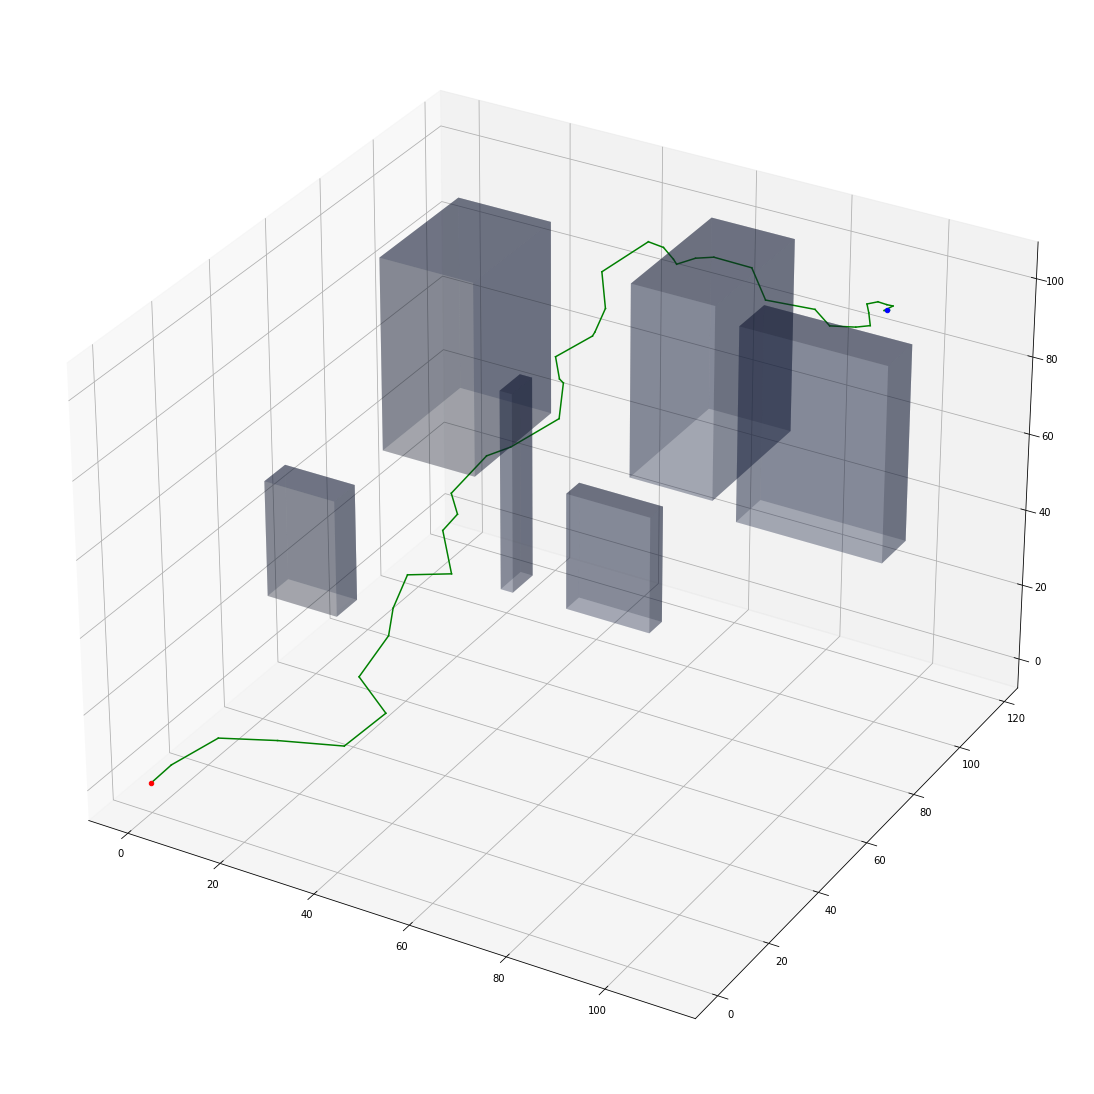

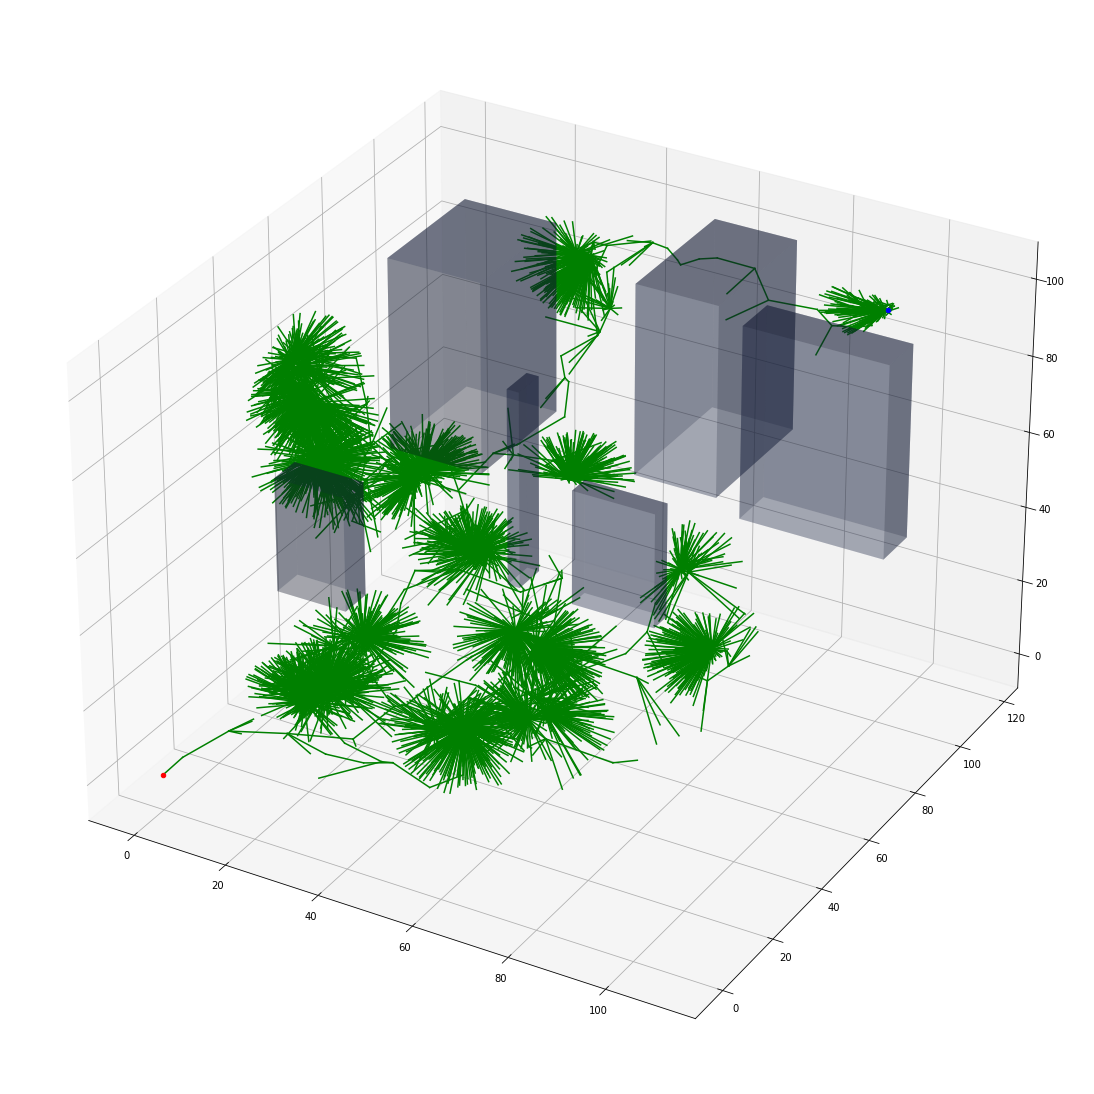

In [8]:
results = HolonomicRRT(env, rrt)
results.show_path()
results.show_tree()

100%|██████████| 42/42 [00:00<00:00, 382958.19it/s]


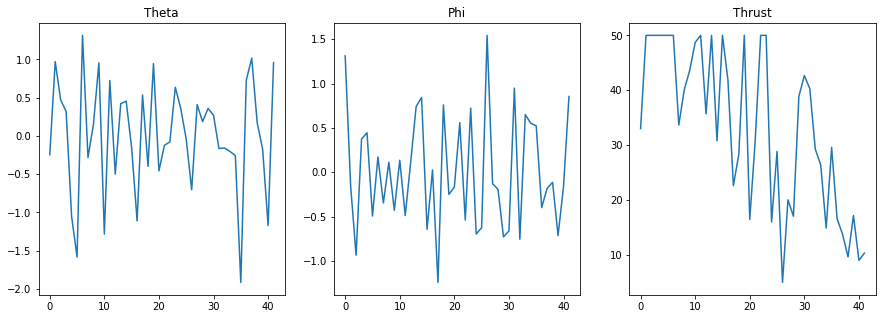

In [9]:
results.plot_controls()